Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name)).split()
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
count = collections.Counter(words).most_common(5)
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)
    
dictionary

{'and': 2, 'in': 4, 'of': 1, 'one': 3, 'the': 0}

In [6]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
    
  # Word frequency map
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Let's convert it to a dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  
  # Cont all of the unknown words (not in the subset of count - first [vocabulary_size - 1] entries)
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
        
    # data will hold all frequences in one-dimensional vector
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [8]:
data[0:10]

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]

Function to generate a training batch for the skip-gram model.

In [9]:
import logging

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # debug_here()
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  # Outer loop for which iterates over subset of data [skip1, skip2, ..., skipN]
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    
    # Inner loop - iterate over current window and randomly select a label for a target
    for j in range(num_skips):
      logging.debug("i - {0}, j - {1}, target - {2}".format(i, j, reverse_dictionary[buffer[target]]))
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      
      # i * num_skips - current skip window index; j - current position inside skip window; i * num_skips + j - current global position in batch
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
      logging.debug("item - {0}, label - {1}".format(reverse_dictionary[buffer[skip_window]], reverse_dictionary[buffer[target]]))
    buffer.append(data[data_index])
    
    s = "Buffer -"
    for i in buffer:
        s += (" " + reverse_dictionary[i])
        
    logging.debug(s)
    
    data_index = (data_index + 1) % len(data)
  return batch, labels

trace = False
logger = logging.getLogger()
if trace:
    logger.setLevel(logging.DEBUG)
else:
    logger.setLevel(logging.INFO)

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'term', 'a', 'originated', 'as', 'term', 'of']


Train a skip-gram model.

In [66]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [67]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.920718
Nearest to at: endeavour, flooding, dearborn, cholesterol, rao, blends, five, saga,
Nearest to also: honduran, sidekick, comma, restraints, avro, batsman, brainiac, neanderthal,
Nearest to will: sinan, grainy, tunes, repealing, manichaeism, perlman, sourcewatch, meddle,
Nearest to b: sacro, tardis, magenta, sql, contemplate, print, fermilab, sheedy,
Nearest to for: klux, serena, maximally, zariski, anomalies, underscore, timeline, redshift,
Nearest to used: extensions, emi, overlordship, poitou, brotherhood, deluded, curious, gamow,
Nearest to to: bovine, cheated, khanty, bearable, graces, applicable, cartoonists, hypotension,
Nearest to over: friendship, perp, branagh, laserdisc, althusser, sul, charley, fetal,
Nearest to UNK: alexander, donohue, ineffective, oj, cma, thujone, outlaw, soi,
Nearest to only: tycho, ana, belgrano, secured, noises, cosmology, pedro, supine,
Nearest to it: singularly, argo, ua, cromarty, gil, nongovernmental, la

In [68]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

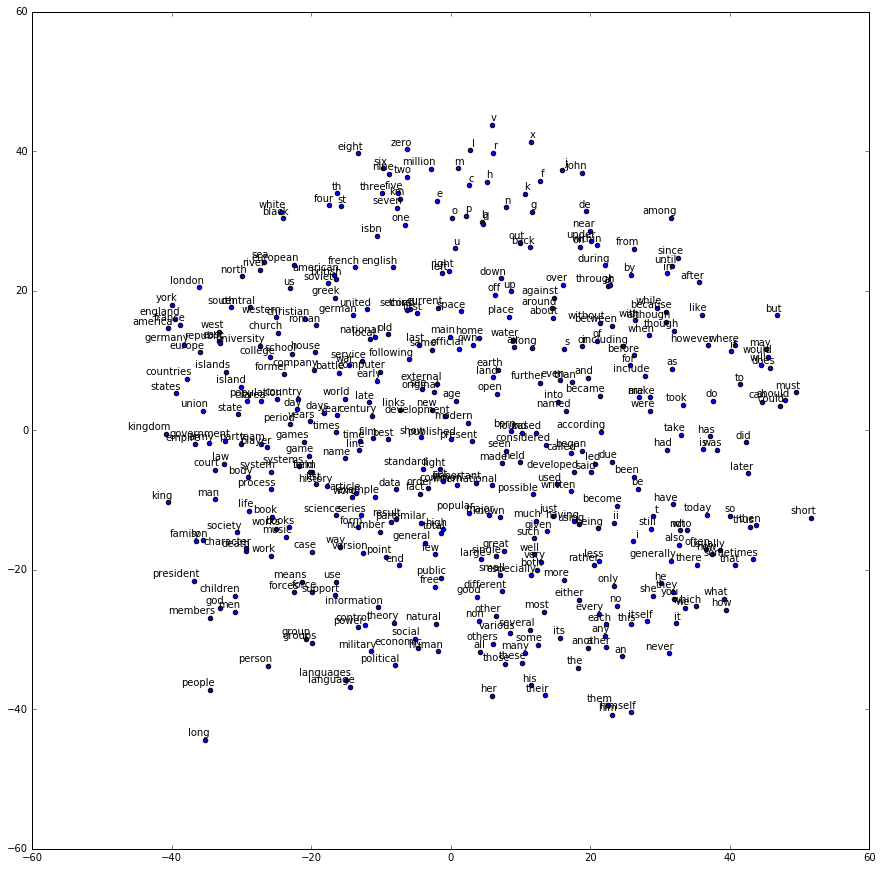

In [71]:
%matplotlib inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [74]:
data_index = 0

def generate_batch_cbow(batch_size, skip_window):
  global data_index
  context_window = 2 * skip_window # calculate the context_window - this is the total number of words around the target
  assert batch_size % context_window == 0 # ensure the context window can be taken from the batch size
  num_labels = batch_size / context_window # the number of labels is the how many context windows fit in the batch
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(num_labels):
    target = skip_window  # target label at the center of the buffer
    labels[i, 0] = buffer[target] # set the label
    targets_to_avoid = [ skip_window ]
    for j in range(context_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * context_window + j] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

skip_window = 1
batch, labels = generate_batch_cbow(8, skip_window)
print("batch - %s" % batch)
print(np.shape(labels))
for i in range(8):
  print(batch[i], '->', labels[i/(2*skip_window), 0])
  print(reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i/(2*skip_window), 0]])
del skip_window # remove skip_window setting used for testing

batch - [5239   12    6 3084  195   12    6    2]
(4, 1)
5239 -> 3084
anarchism -> originated
12 -> 3084
as -> originated
6 -> 12
a -> as
3084 -> 12
originated -> as
195 -> 6
term -> a
12 -> 6
as -> a
6 -> 195
a -> term
2 -> 195
of -> term


In [76]:

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 32 # Number of negative examples to sample.

## General defines
context_window = 2 * skip_window
num_labels = batch_size / context_window

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[num_labels, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # seq_ids only needs to be generated once so do this as a numpy array rather than a tensor.
  seq_ids = np.zeros(batch_size, dtype=np.int32)
  cur_id = -1
  for i in range(batch_size):
    if i % context_window == 0:
      cur_id = cur_id + 1
    seq_ids[i] = cur_id
  print(seq_ids)
  
  # use segment_sum to add together the related words and reduce the output to be num_labels in size.
  final_embed = tf.segment_sum(embed, seq_ids)
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, final_embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37
 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49 49
 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60 60 61 61 62
 62 63 63]


In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  #saver = tf.train.Saver()
  print("Initialized")
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step", step, ":", average_loss)
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print(log)
    final_embeddings = normalized_embeddings.eval()
    #saver.save(session, 'cbow_word2vec', global_step = 0)
    

Initialized
Average loss at step 0 : 7.25171279907
Nearest to some: switch, knock, fokker, soar, biennial, aoe, answers, workplaces,
Nearest to by: stoves, sanchez, noll, medically, axel, reviving, subunits, tnt,
Nearest to for: carangi, wastewater, voc, amphibious, angell, cim, shortly, cupid,
Nearest to d: dirt, iff, vestalia, informants, parisians, falsificationism, kilobit, cochrane,
Nearest to only: coffey, superlatives, connoisseur, mystics, clicked, inn, foundered, colonists,
Nearest to after: compel, aboard, jama, chipping, hacked, nightingale, yyyy, pulleys,
Nearest to most: tiffany, mourner, geller, investigation, stamped, rosie, weeping, jacky,
Nearest to one: filmed, ko, mrnas, finitely, dissolution, story, aspects, alton,
Nearest to or: escap, organization, mariani, pepper, witches, fullwidth, supervise, eyelids,
Nearest to th: habitual, dissipates, borgia, mite, dominating, mandola, caliphs, maglev,
Nearest to he: maneuverability, coen, abstained, taklamakan, inciting, se

In [86]:
num_points = 400

with tf.Session(graph=graph) as session:
  final_embeddings = embeddings.eval()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: _send_Variable_0 = _Send[T=DT_FLOAT, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-3898884239234834331, tensor_name="Variable:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]